# Gaussian Process 

### Data Training

In [1]:
import sys
import os
import time
import torch

import matplotlib.pyplot as plt
import numpy as np

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

# from elliptic_files.train_elliptic import samples_param
from elliptic2d_files.FEM2d_Solver import Elliptic2D_FEM
from Base.utilities import RootFinder,compute_seq_pairs

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Kernel Function with derivatives

In [2]:

class KernelFunction:
    def __init__(self, device):
        self.device = device

    def euclidean_distance(self, X, Y):
        return torch.cdist(X, Y)
    
    def d_euclidean_distance(self, X, Y):
        """
        X: (n, d)
        Y: (m, d)
        Returns:
        dr_dX: (n, m, d) - ∂r_{ij}/∂X_i
        dr_dY: (n, m, d) - ∂r_{ij}/∂Y_j
        """
        delta = X[:, None, :] - Y[None, :, :]   # shape: (n, m, d)

        dists = torch.linalg.norm(delta, dim=2)  # shape: (n, m)

        zero_mask = (dists == 0)
        dists_safe = torch.where(zero_mask, torch.ones_like(dists), dists)  # to avoid divide by zero

        dr_dX = delta / dists_safe[..., None]   # shape: (n, m, d)
        dr_dX = torch.where(zero_mask[..., None], torch.zeros_like(dr_dX), dr_dX)

        dr_dY = -dr_dX
        return dr_dX, dr_dY,delta
    
    
    def kernel(self,derivative_order=0):
        raise NotImplementedError("covariance must be implemented in a subclass.")
    
    def covariance(self, X,Y=None, derivative_order=0):
        Y = X if Y is None else Y.to(dtype=X.dtype)
        d = self.euclidean_distance(X, Y)
        return self.kernel(d, derivative_order=derivative_order)
        

class MaternKernel(KernelFunction):
    def __init__(self, sigma=1.0, l=1.0, device='cpu'):
        super().__init__(device)
        self._sigma = torch.tensor(sigma, dtype=torch.float64, device=device)
        self._l = torch.tensor(l, dtype=torch.float64, device=device)
        self.sqrt5 = torch.sqrt(torch.tensor(5.0, dtype=torch.float64, device=device))

    @property
    def sigma(self):
        return self._sigma

    @sigma.setter
    def sigma(self, new_sigma):
        if not isinstance(new_sigma, torch.Tensor):
            new_sigma = torch.tensor(new_sigma, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_sigma = new_sigma.to(dtype=torch.float64, device=self.device)
        self._sigma = new_sigma

    @property
    def l(self):
        return self._l

    @l.setter
    def l(self, new_l):
        if not isinstance(new_l, torch.Tensor):
            new_l = torch.tensor(new_l, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_l = new_l.to(dtype=torch.float64, device=self.device)
        self._l = new_l

    def matern52_kernel(self, r):
        term1 = 1 + self.sqrt5 * r / self.l + 5 * r**2 / (3 * self.l**2)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def d_matern52_kernel(self, r):
        term1 = -(5 / 3) * (r / self.l**2) - (self.sqrt5 * 5 * r**2) / (3 * self.l**3)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)

    def dd_matern52_kernel(self, r):
        term1 = -5 / (3 * self.l**2) - (5 / 3) * (r * self.sqrt5 / self.l**3) + (25 * r**2) / (3 * self.l**4)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def ddd_matern52_kernel(self, r):
        #term1 = 25 / (3 * self.l**4) + (75 * r)/ (3 * self.l**4) -  (25 * self.sqrt5 * r**2)/ (3 * self.l**5)
        term1 = (75 * r)/ (3 * self.l**4) -  (25 * self.sqrt5 * r**2)/ (3 * self.l**5)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def dddd_matern52_kernel(self, r):
        #term1 = 50 / (3 * self.l**4) - (25 * self.sqrt5)/ (3 * self.l**5) + (r**2 * 5**3) / (3*self.l**6)
        term1 = 75 / (3 * self.l**4) - (125 * self.sqrt5*r)/ (3 * self.l**5) + (r**2 * 125) / (3*self.l**6)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def d_matern_rrr(self,r):
        term1 = -(5 / 3) * (1/ r*self.l)**2 - (self.sqrt5 * 5 ) / (3 *r* self.l**3)
        zero_mask = r == 0
        term1 = torch.where(zero_mask, torch.zeros_like(term1), term1)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)

    def dd_matern_rr(self,r):
        # Compute all terms with masking for r == 0
        common_term = (25) / (3 * self.l**4)
        mask = r == 0
        # Only apply division where r != 0
        term1 = -5 / (3 * (r*self.l)**2) - (5 / 3) * (self.sqrt5 / (r*self.l**3))
        term1 = torch.where(mask, torch.zeros_like(term1), term1)

        full_term = term1 + common_term
        return self.sigma**2 * full_term * torch.exp(-self.sqrt5 * r / self.l)

    def ddd_matern_r(self,r):
        term1 = 75/ (3 * self.l**4) -  (25 * self.sqrt5 * r)/ (3 * self.l**5)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def d_sdd_matern(self,r):
        term1 = -(5 / 3) * (1/self.l)**2 - (5 / 3) * (self.sqrt5*r / self.l**3)
        term2 = 25 / (3 * self.l**4)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l), self.sigma**2 * term2 * torch.exp(-self.sqrt5 * r / self.l)
    
    def d_dd_matern(self, r):
        term1 = -25 / (3 * self.l**4)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def d_ssdd_matern(self,r):
        term1 = -(10 / 3) * (1/self.l)**2 - (10 / 3) * (self.sqrt5*r / self.l**3) + (25*r**2) / (3 * self.l**4)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)

    def kernel(self, r, derivative_order=0):
        if derivative_order == 0:
            return self.matern52_kernel(r)
        elif derivative_order == 1:
            return self.d_matern52_kernel(r)
        elif derivative_order == 2:
            return self.dd_matern52_kernel(r)
        elif derivative_order == 3:
            return self.ddd_matern52_kernel(r)
        elif derivative_order == 4:
            return self.dddd_matern52_kernel(r)
        elif derivative_order == -1:
            return self.d_matern_rrr(r)
        elif derivative_order == -2:
            return self.dd_matern_rr(r)
        elif derivative_order == -3:
            return self.ddd_matern_r(r)
        elif derivative_order == -4:
            return self.d_sdd_matern(r)
        elif derivative_order == -5:
            return self.d_dd_matern(r)
        elif derivative_order == -6:
            return self.d_ssdd_matern(r)
        else:
            raise ValueError(f"Unsupported derivative order: {derivative_order}")

class SquaredExponential(KernelFunction):
    def __init__(self, sigma=1.0, l=1.0, device='cpu'):
        super().__init__(device)
        self._sigma = torch.tensor(sigma, dtype=torch.float64, device=device)
        self._l = torch.tensor(l, dtype=torch.float64, device=device)

    @property
    def sigma(self):
        return self._sigma

    @sigma.setter
    def sigma(self, new_sigma):
        if not isinstance(new_sigma, torch.Tensor):
            new_sigma = torch.tensor(new_sigma, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_sigma = new_sigma.to(dtype=torch.float64, device=self.device)
        self._sigma = new_sigma

    @property
    def l(self):
        return self._l

    @l.setter
    def l(self, new_l):
        if not isinstance(new_l, torch.Tensor):
            new_l = torch.tensor(new_l, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_l = new_l.to(dtype=torch.float64, device=self.device)
        self._l = new_l

    def squared_exponential_cov(self, r):
        return (self.sigma**2) * torch.exp(-0.5 * (r / self.l) ** 2)

    def d_squared_exponential_cov(self, r):
        return -((self.sigma / self.l) ** 2) * r * torch.exp(-0.5 * (r / self.l) ** 2)

    def dd_squared_exponential_cov(self, r):
            return (-1/self.l**2 + r**2/self.l**4 )*self.squared_exponential_cov(r)
    
    def ddd_squared_exponential_cov(self, r):
            return (3*r / self.l**4 - r**3 / self.l**6)*self.squared_exponential_cov(r)
    
    def dddd_squared_exponential_cov(self, r):
            return (3 / self.l**4 - 6*r**2 /self.l**6 + r**4 / self.l**8)*self.squared_exponential_cov(r)

    def kernel(self, r, derivative_order=0):
        if derivative_order == 0:
            return self.squared_exponential_cov(r)
        elif derivative_order == 1:
            return self.d_squared_exponential_cov(r)
        elif derivative_order == 2:
            return self.dd_squared_exponential_cov(r)
        elif derivative_order == 3:
            return self.ddd_squared_exponential_cov(r)
        elif derivative_order == 4:
            return self.dddd_squared_exponential_cov(r)
        else:
            raise ValueError(f"Unsupported derivative order: {derivative_order}")


In [3]:
X = torch.tensor([[1.0, 1.0],
                   [1.0, 2.0],
                   [2.0, 1.0],
                   [2.0, 2.0]])  # shape (2, 2)

Y = torch.tensor([[5.0, 6.0],
                   [7.0, 8.0],
                   [9.0, 10.0]])  # shape (3, 2)

kernel_parameter = MaternKernel()
kernel_parameter.covariance(X,X,derivative_order=-3)

tensor([[25.0000,  0.6804,  0.6804, -0.0572],
        [ 0.6804, 25.0000, -0.0572,  0.6804],
        [ 0.6804, -0.0572, 25.0000,  0.6804],
        [-0.0572,  0.6804,  0.6804, 25.0000]])

# Main PIGP initiliazer and covaraince matrix builder

In [4]:
class PIGP:
     def __init__(self, data_training,reg_matrix=1e-6, sigma_l_parameters=(1, 1), sigma_l_spatial=(1, 1),device = "cpu"):
          self.device = device
          # Training data
          self.parameters_data = torch.tensor(data_training["parameters_data"], dtype=torch.float64)
          self.solutions_data = torch.tensor(data_training["solutions_data"], dtype=torch.float64)
          self.x_sol_data = torch.tensor(data_training["x_solutions_data"], dtype=torch.float64)

          self.x_bc = torch.tensor(data_training["x_bc"], dtype=torch.float64)
          self.y_bc = torch.tensor(data_training["y_bc"], dtype=torch.float64)

          self.source_func_x = torch.tensor(data_training["source_func_x"], dtype=torch.float64)
          self.source_func_f_x = torch.tensor(data_training["source_func_f_x"], dtype=torch.float64)

          self.n_parameter_obs = self.parameters_data.shape[0]
          self.parameter_dim = self.parameters_data.shape[-1]

          self.kernel_parameter = SquaredExponential(*sigma_l_parameters,device=self.device)
          self.kernel_spatial = MaternKernel(*sigma_l_spatial,device=self.device)
          
          self.reg_matrix = reg_matrix

          
     def train_gp(self):
          self.g_trained = self.g_training()
          self.kuf = self.kernel_uf(self.parameters_data,self.x_sol_data)
          self.cov_matrix, self.kuu, self.kug = self.informed_kernel(self.parameters_data, self.parameters_data)
          self.invk_g = self.kernel_inverse(self.cov_matrix, self.g_trained)

     
     def exp_kl_eval(self, theta, x):
        """Define the likelihood function for the coarse model. Must be overridden."""
        raise NotImplementedError("log_likelihood must be implemented in a subclass.")
     
     def grad_kl_eval(self, theta, x):
        """Define the likelihood function for the coarse model. Must be overridden."""
        raise NotImplementedError("log_likelihood must be implemented in a subclass.")
    
     
     def kernel_uf(self, theta, x):
          exp_kl = self.exp_kl_eval(theta, self.source_func_x)  # [B, S]
          grad_kl_x, grad_kl_y = self.grad_kl_eval(theta, self.source_func_x)  # ([B, S], [B, S])

          # Derivatives of pairwise distance r(x, s)
          _, dr_dx,_ = self.kernel_spatial.d_euclidean_distance(x, self.source_func_x)  # [N, S, d]
          dk_dr = self.kernel_spatial.covariance(x, self.source_func_x, derivative_order=1)  # [N, S]
          d_ddk = self.kernel_spatial.covariance(x, self.source_func_x, derivative_order=-6)  # [N, S]

          # Reshape for broadcasting
          exp_kl = exp_kl.unsqueeze(1)         # [B, 1, S]
          grad_kl_x = grad_kl_x.unsqueeze(1)   # [B, 1, S]
          grad_kl_y = grad_kl_y.unsqueeze(1)   # [B, 1, S]

          dr_dx = dr_dx       # [S, N, d] → want [N, S, d]
          dr_dx_x1 = dr_dx[...,0].unsqueeze(0) # [1, N, S]
          dr_dx_x2 = dr_dx[...,1].unsqueeze(0) # [1, N, S]

          dk_dr = dk_dr.unsqueeze(0)         # [S, N] → [1,N, S]
          d_ddk = d_ddk.unsqueeze(0)      # [S, N] → [1, N, S]

          grad_proj = grad_kl_x * dr_dx_x1 + grad_kl_y * dr_dx_x2  # [B, N, S]

          pi_gp = grad_proj * dk_dr + d_ddk  # [B, N, S]
          return -pi_gp * exp_kl  # [B, N, S]
     
     def kernel_ff(self, theta1, theta2):
          exp_kl1 = self.exp_kl_eval(theta1, self.source_func_x).view(-1, 1)
          grad_kl1_x, grad_kl1_y = self.grad_kl_eval(theta1, self.source_func_x)
          grad_kl1_x, grad_kl1_y = grad_kl1_x.view(-1, 1), grad_kl1_y.view(-1, 1)
          exp_kl2 = self.exp_kl_eval(theta2, self.source_func_x).view(-1, 1)
          grad_kl2_x, grad_kl2_y = self.grad_kl_eval(theta2, self.source_func_x)
          grad_kl2_x, grad_kl2_y = grad_kl2_x.view(-1, 1), grad_kl2_y.view(-1, 1) 

          _, _,delta = self.kernel_spatial.d_euclidean_distance(self.source_func_x, self.source_func_x)  # [N, S, d]
          # dk = self.kernel_spatial.covariance(self.source_func_x, self.source_func_x, derivative_order=-1)  # [N, S]
          # ddk = self.kernel_spatial.covariance(self.source_func_x, self.source_func_x, derivative_order=-2)  # [N, S]
          dddk = self.kernel_spatial.covariance(self.source_func_x, self.source_func_x, derivative_order=-3)  # [N, S]
          ddddk = self.kernel_spatial.covariance(self.source_func_x, self.source_func_x, derivative_order=4)  # [N, S]
          d_ddk1,d_ddk2  = self.kernel_spatial.covariance(self.source_func_x, self.source_func_x, derivative_order=-4)  # [N, S]
          d_ddk  = self.kernel_spatial.covariance(self.source_func_x, self.source_func_x, derivative_order=-5)  # [N, S]

          llk1 = -grad_kl1_x*grad_kl2_x.T*(d_ddk1 + delta[...,0]**2*d_ddk2) + \
                    grad_kl1_y*grad_kl2_x.T*( delta[...,0]* delta[...,1])*d_ddk +\
                    grad_kl1_x*grad_kl2_y.T*( delta[...,0]* delta[...,1])*d_ddk -\
                     grad_kl1_y*grad_kl2_y.T*(d_ddk1 + delta[...,1]**2*d_ddk2)

          llk2 = (grad_kl1_x*delta[...,0] + grad_kl1_y*delta[...,1])*(-d_ddk + dddk)
          llk3 = (grad_kl2_x.T*delta[...,0] + grad_kl2_y.T*delta[...,1])*(d_ddk - dddk)
          llk4 = d_ddk + 2*dddk + ddddk

          return (llk1 + llk2 + llk3 + llk4)*exp_kl1*exp_kl2.T


     def block_matrix_builder_ff(self, th1, th2):
          nth1, nth2 = th1.shape[0], th2.shape[0]
          blocks = []

          for i in range(nth1):
               row_blocks = []
               for j in range(nth2):
                    theta1 = th1[i, :]
                    theta2 = th2[j, :]
                    cov_scalar = self.kernel_parameter.covariance(theta1.view(1, -1), theta2.view(1, -1))
                    pde_matrix = self.kernel_ff(theta1.unsqueeze(0), theta2.unsqueeze(0))
                    row_blocks.append(cov_scalar * pde_matrix)
               blocks.append(torch.cat(row_blocks, dim=1))
          return torch.cat(blocks, dim=0)
    

     def block_matrix_builder_uf(self, th1, th2, x = None):
          cov_matrix = self.kernel_parameter.covariance(th1, th2)  # [nth1, nth2]

          if x is None:
               pde_matrices = self.kuf # [nth2, N, S]
               x = self.x_sol_data
          else:
               pde_matrices = self.kernel_uf(th2, x)

          # Broadcast cov scalars over PDEs
          # [nth1, nth2, 1, 1] * [1, nth2, N, S] → [nth1, nth2, N, S]
          blocks = cov_matrix.unsqueeze(-1).unsqueeze(-1) * pde_matrices.unsqueeze(0)

          # Stack the final block matrix
          result = torch.cat(
               [blocks[i].transpose(0, 1).reshape(x.shape[0], -1) for i in range(th1.shape[0])],
               dim=0
          )  # shape: [nth1 * N, nth2 * S]
          return result


     def informed_kernel(self, theta1, theta2):
          kernel_param = self.kernel_parameter.covariance(theta1, theta2)

          kuu = self.kernel_spatial.covariance(self.x_sol_data, self.x_sol_data)
          Kuu = torch.kron(kernel_param, kuu)

          kug = self.kernel_spatial.covariance(self.x_sol_data, self.x_bc)
          Kug = torch.kron(kernel_param, kug)

          Kuf = self.block_matrix_builder_uf(theta1, theta2)

          kgg = self.kernel_spatial.covariance(self.x_bc, self.x_bc)
          Kgg = torch.kron(kernel_param, kgg)

          Kgf = self.block_matrix_builder_uf(theta1, theta2, self.x_bc)
          Kff = self.block_matrix_builder_ff(theta1, theta2)

          top = torch.cat([Kuu, Kug, Kuf], dim=1)
          middle = torch.cat([Kug.T, Kgg, Kgf], dim=1)
          bottom = torch.cat([Kuf.T, Kgf.T, Kff], dim=1)
          cov = torch.cat([top, middle, bottom], dim=0)

          return cov + self.reg_matrix * torch.eye(cov.shape[0], dtype=torch.float64),kuu,kug

     def g_training(self):
          y_bc_n = self.y_bc.repeat((self.n_parameter_obs,1))
          f_source_n = self.source_func_f_x.repeat((self.n_parameter_obs,1))
          return torch.cat([self.solutions_data.view(-1, 1), y_bc_n, f_source_n])

     def kernel_inverse(self, cov_matrix, Y):
          return torch.linalg.solve(cov_matrix, Y)

     def marginal_likelihood(self, sigma_spatial, l_spatial, sigma_param, l_param):
          # Update kernel parameters
          self.kernel_spatial.sigma, self.kernel_spatial.l = sigma_spatial, l_spatial
          self.kernel_parameter.sigma, self.kernel_parameter.l = sigma_param, l_param

          # Recompute the covariance matrix
          self.kuf = self.kernel_uf(self.parameters_data,self.x_sol_data)
          self.cov_matrix, _, _ = self.informed_kernel(self.parameters_data, self.parameters_data)
          
          # Compute Cholesky
          L = torch.linalg.cholesky(self.cov_matrix)

          # Solve K^{-1}y
          y = self.g_trained
          alpha =self.kernel_inverse(self.cov_matrix,y)

          # Log determinant
          logdet_K = 2.0 * torch.sum(torch.log(torch.diag(L)))
          return -0.5 * ((y.T @ alpha).squeeze() + logdet_K + y.shape[0] * np.log(2 * np.pi))


     def optimize_mll(self, lr=1e-2):
     # Start from log of current parameters
          log_sigma_spatial = self.kernel_spatial.sigma.detach().log().clone().requires_grad_()
          log_l_spatial = self.kernel_spatial.l.detach().log().clone().requires_grad_()
          log_sigma_param = self.kernel_parameter.sigma.detach().log().clone().requires_grad_()
          log_l_param = self.kernel_parameter.l.detach().log().clone().requires_grad_()

          params = [log_sigma_spatial, log_l_spatial, log_sigma_param, log_l_param]
          optimizer = torch.optim.LBFGS(params, lr=lr, max_iter=100, line_search_fn='strong_wolfe')

          def closure():
               optimizer.zero_grad()

               # Exponentiate to ensure positivity
               sigma_spatial = log_sigma_spatial.exp()
               l_spatial = log_l_spatial.exp()
               sigma_param = log_sigma_param.exp()
               l_param = log_l_param.exp()

               nll = -self.marginal_likelihood(sigma_spatial, l_spatial, sigma_param, l_param)
               nll.backward()
               return nll

          optimizer.step(closure)

          # Update final values after optimization
          self.kernel_spatial.sigma = log_sigma_spatial.exp().detach()
          self.kernel_spatial.l = log_l_spatial.exp().detach()
          self.kernel_parameter.sigma = log_sigma_param.exp().detach()
          self.kernel_parameter.l = log_l_param.exp().detach()

          print("Optimized parameters:")
          print(f"(sigma_spatial,l_spatial) = ({self.kernel_spatial.sigma},{self.kernel_spatial.l})")
          print(f"(sigma_parameter,l_parameter) = ({self.kernel_parameter.sigma},{self.kernel_parameter.l})")
          self.train_gp()

     def marginal_val(self, theta_test, x_test=None):
          kernel_param = self.kernel_parameter.covariance(theta_test, self.parameters_data)

          if x_test is None:
               x_test = self.x_sol_data
               Kuf = self.block_matrix_builder_uf(theta_test, self.parameters_data)
               kuu = self.kuu
               kug = self.kug
          else: 
               Kuf = self.block_matrix_builder_uf(theta_test, self.parameters_data,x_test)

               kuu = self.kernel_spatial.covariance(x_test, self.x_sol_data)
               
               kug = self.kernel_spatial.covariance(x_test, self.x_bc)

          Kuu = torch.kron(kernel_param, kuu)

          Kug = torch.kron(kernel_param, kug)
          
          return torch.cat([Kuu, Kug, Kuf], dim=1)

     def prediction(self, theta_test, x_test=None, var=True):

          matrix_test = self.marginal_val(theta_test, x_test)
          marginal_mean = matrix_test @ self.invk_g

          if var:
               kernel_spatial = self.kuu if x_test is None else  self.kernel_spatial.covariance(x_test, x_test)
               kernel_param = self.kernel_parameter.covariance(theta_test, theta_test)
               kinv_y = self.kernel_inverse(self.cov_matrix, matrix_test.T)
               cov = torch.kron(kernel_param, kernel_spatial) - matrix_test @ kinv_y
               return marginal_mean, cov
          return marginal_mean

# PIGP for the Elliptic I just added some the KL expansion part

In [5]:

# class EllipticPIGP(PIGP):
#     def __init__(self, data_training, reg_matrix=1e-6, lam=1/4,sigma_l_parameters=(1, 1), sigma_l_spatial=(1, 1),device = "cpu"):
#         super(EllipticPIGP, self).__init__(data_training = data_training , reg_matrix=reg_matrix,
#                              sigma_l_parameters=sigma_l_parameters, sigma_l_spatial=sigma_l_spatial,device=device)
            
#         # Roots for KL
#         self.eigen_pairs = compute_seq_pairs(self.parameter_dim)
#         self.finder = RootFinder(lam, self.parameter_dim)
#         self.roots = torch.tensor(self.finder.find_roots(), dtype=torch.float64)
#         self.kuf = self.kernel_uf(self.parameters_data,self.x_sol_data)


#     @property
#     def A(self):
#         r = self.roots
#         return torch.sqrt(1 / ((1/8)*(5 + (r / 2)**2) + 
#                             (torch.sin(2*r) / (4*r)) * ((r / 4)**2 - 1) - (torch.cos(2*r)/8)))
#     @property
#     def an(self):
#         return torch.sqrt(8 / (self.roots**2 + 16))
    
#     def exp_kl_eval(self, theta, x):
#         kx = torch.tensor([p[0] for p in self.eigen_pairs], device=self.device)  # (terms_sum,)
#         ky = torch.tensor([p[1] for p in self.eigen_pairs], device=self.device)

#         an_kx = self.an[kx]  # (terms_sum,)
#         an_ky = self.an[ky]

#         roots_kx = self.roots[kx].squeeze(-1)  # (terms_sum,)
#         roots_ky = self.roots[ky].squeeze(-1)
#         A_kx = self.A[kx].squeeze(-1)
#         A_ky = self.A[ky].squeeze(-1)

#         x0 = x[:, 0]  # (obs,)
#         x1 = x[:, 1]  # (obs,)
        
#         # Shape: (terms_sum, obs)
#         phi_kx = A_kx[:, None] * (torch.sin(roots_kx[:, None] * x0[None, :]) +
#             (roots_kx[:, None] / 4) * torch.cos(roots_kx[:, None] * x0[None, :]))

#         phi_ky = A_ky[:, None] * ( torch.sin(roots_ky[:, None] * x1[None, :]) +
#             (roots_ky[:, None] / 4) * torch.cos(roots_ky[:, None] * x1[None, :]))

#         # 4. Basis terms
#         v_ij = an_kx * an_ky  # (terms_sum,)
#         basis_terms = v_ij[:, None] * phi_kx * phi_ky  # (terms_sum, obs)

#         result = torch.matmul(theta, basis_terms)

#         return torch.exp(result)

#     def grad_kl_eval(self, theta, x):
#         kx = torch.tensor([p[0] for p in self.eigen_pairs], device=self.device)  # (terms_sum,)
#         ky = torch.tensor([p[1] for p in self.eigen_pairs], device=self.device)

#         an_kx = self.an[kx]  # (terms_sum,)
#         an_ky = self.an[ky]

#         roots_kx = self.roots[kx].squeeze(-1)  # (terms_sum,)
#         roots_ky = self.roots[ky].squeeze(-1)
#         A_kx = self.A[kx].squeeze(-1)
#         A_ky = self.A[ky].squeeze(-1)

#         x0 = x[:, 0]  # (obs,)
#         x1 = x[:, 1]  # (obs,)

#         # Shape: (terms_sum, obs)
#         phi_kx = A_kx[:, None] * (torch.sin(roots_kx[:, None] * x0[None, :]) +
#             (roots_kx[:, None] / 4) * torch.cos(roots_kx[:, None] * x0[None, :]))
        
#         phi_prime_kx = A_kx[:, None]  * roots_kx[:, None] * (
#                     torch.cos(roots_kx[:, None] * x0[None, :]) - (roots_kx[:, None] / 4) * torch.sin(roots_kx[:, None] * x0[None, :]))

#         phi_ky = A_ky[:, None] * ( torch.sin(roots_ky[:, None] * x1[None, :]) +
#             (roots_ky[:, None] / 4) * torch.cos(roots_ky[:, None] * x1[None, :]))
        
#         phi_prime_ky = A_ky[:, None]  * roots_ky[:, None] * (
#                 torch.cos(roots_ky[:, None] * x1[None, :]) - (roots_ky[:, None] / 4) * torch.sin(roots_ky[:, None] * x1[None, :]))

#         v_ij = an_kx * an_ky  # (terms_sum,)
#         basis_grad_x = v_ij[:, None] * phi_prime_kx * phi_ky  # (terms_sum, obs)
#         basis_grad_y = v_ij[:, None] * phi_kx * phi_prime_ky
        
#         return theta @ basis_grad_x,theta @ basis_grad_y

In [6]:
class EllipticPIGP(PIGP):
    def __init__(self, data_training, reg_matrix=1e-6, lam=1/4,sigma_l_parameters=(1, 1), sigma_l_spatial=(1, 1),device = "cpu"):
        super(EllipticPIGP, self).__init__(data_training = data_training , reg_matrix=reg_matrix,
                             sigma_l_parameters=sigma_l_parameters, sigma_l_spatial=sigma_l_spatial,device=device)
            
        # Roots for KL
        #self.eigen_pairs = compute_seq_pairs(self.parameter_dim)
        self.trunc_Nx = int(np.ceil(0.5*self.parameter_dim + 1))
        self.finder = RootFinder(lam, self.trunc_Nx)
        self.roots = torch.tensor(self.finder.find_roots(), dtype=torch.float64)
        self.kuf = self.kernel_uf(self.parameters_data,self.x_sol_data)


    @property
    def A(self):
        r = self.roots
        return torch.sqrt(1 / ((1/8)*(5 + (r / 2)**2) + 
                            (torch.sin(2*r) / (4*r)) * ((r / 4)**2 - 1) - (torch.cos(2*r)/8)))
    @property
    def an(self):
        return torch.sqrt(8 / (self.roots**2 + 16))
    
    @property
    def k_terms_order(self):
        v_ij = torch.outer(self.an, self.an).reshape(-1)
        indices = torch.tensor([(i, j) for i in range(self.trunc_Nx) for j in range(self.trunc_Nx)])
        sort_idx = np.argsort(np.array(v_ij))[::-1].copy()
        #sort_idx =torch.tensor()
        v_ij,indices = v_ij[sort_idx],indices[sort_idx]
        v_ij,indices = v_ij[:self.parameter_dim],indices[:self.parameter_dim]
        kx,ky = indices[:, 0],indices[:, 1]
        roots_kx = self.roots[kx].squeeze(-1)  # (terms_sum,)
        roots_ky = self.roots[ky].squeeze(-1)
        A_kx = self.A[kx].squeeze(-1)
        A_ky = self.A[ky].squeeze(-1)  

        return v_ij,A_kx,A_ky,roots_kx,roots_ky
    
    
    def exp_kl_eval(self, theta, x):
        v_ij,A_kx,A_ky,roots_kx,roots_ky = self.k_terms_order
        

        # kx = torch.tensor([p[0] for p in self.eigen_pairs], device=self.device)  # (terms_sum,)
        # ky = torch.tensor([p[1] for p in self.eigen_pairs], device=self.device)

        # an_kx = self.an[kx]  # (terms_sum,)
        # an_ky = self.an[ky]

        x0 = x[:, 0]  # (obs,)
        x1 = x[:, 1]  # (obs,)
        
        # Shape: (terms_sum, obs)
        phi_kx = A_kx[:, None] * (torch.sin(roots_kx[:, None] * x0[None, :]) +
            (roots_kx[:, None] / 4) * torch.cos(roots_kx[:, None] * x0[None, :]))

        phi_ky = A_ky[:, None] * ( torch.sin(roots_ky[:, None] * x1[None, :]) +
            (roots_ky[:, None] / 4) * torch.cos(roots_ky[:, None] * x1[None, :]))

        # 4. Basis terms
        basis_terms = v_ij[:, None] * phi_kx * phi_ky  # (terms_sum, obs)

        result = torch.matmul(theta, basis_terms)

        return torch.exp(result)

    def grad_kl_eval(self, theta, x):
        v_ij,A_kx,A_ky,roots_kx,roots_ky = self.k_terms_order

        # kx = torch.tensor([p[0] for p in self.eigen_pairs], device=self.device)  # (terms_sum,)
        # ky = torch.tensor([p[1] for p in self.eigen_pairs], device=self.device)

        # an_kx = self.an[kx]  # (terms_sum,)
        # an_ky = self.an[ky]

        x0 = x[:, 0]  # (obs,)
        x1 = x[:, 1]  # (obs,)

        # Shape: (terms_sum, obs)
        phi_kx = A_kx[:, None] * (torch.sin(roots_kx[:, None] * x0[None, :]) +
            (roots_kx[:, None] / 4) * torch.cos(roots_kx[:, None] * x0[None, :]))
        
        phi_prime_kx = A_kx[:, None]  * roots_kx[:, None] * (
                    torch.cos(roots_kx[:, None] * x0[None, :]) - (roots_kx[:, None] / 4) * torch.sin(roots_kx[:, None] * x0[None, :]))

        phi_ky = A_ky[:, None] * ( torch.sin(roots_ky[:, None] * x1[None, :]) +
            (roots_ky[:, None] / 4) * torch.cos(roots_ky[:, None] * x1[None, :]))
        
        phi_prime_ky = A_ky[:, None]  * roots_ky[:, None] * (
                torch.cos(roots_ky[:, None] * x1[None, :]) - (roots_ky[:, None] / 4) * torch.sin(roots_ky[:, None] * x1[None, :]))

        #v_ij = an_kx * an_ky  # (terms_sum,)
        basis_grad_x = v_ij[:, None] * phi_prime_kx * phi_ky  # (terms_sum, obs)
        basis_grad_y = v_ij[:, None] * phi_kx * phi_prime_ky
        
        return theta @ basis_grad_x,theta @ basis_grad_y

# Numerical Test

In [7]:
rng = np.random.default_rng(42)

obs, nthetas = 6, 20
nparams = 2

thetas = rng.uniform(low = -1,high = 1,size=(nthetas,nparams))
fem_solver = Elliptic2D_FEM(np.zeros(nparams),ncells = 30)
obs_points = rng.uniform(low=0.0, high=1.0, size=(obs, 2))
points_fem = np.hstack((obs_points, np.zeros((obs_points.shape[0], 1))))

training_data = np.zeros((nthetas,obs ))
for i,tht in enumerate(thetas):
    fem_solver.theta = tht
    
    start = time.time()
    fem_solver.solve()
    end = time.time()
    print(f"Time taken: {end - start} seconds")

    training_data[i,:] = fem_solver.evaluate_at_points(points_fem).reshape(1, -1)

xf = np.array([
    [0.2, 0.2],
    [0.8, 0.2],
    [0.2, 0.8],
    [0.8, 0.8],
    [0.5, 0.5],
    [0.2, 0.5],
    [0.5, 0.2],
    [0.8, 0.58],
    [0.35, 0.],
    [0.5, 0.35]
])

yf = 4 * xf[:, 0] * xf[:, 1]

grid = torch.linspace(0.1, 0.9, 5)

# Bottom edge: y=0
bottom = torch.stack([grid, torch.full_like(grid, 0)], dim=1)

# Top edge: y=1
top = torch.stack([grid, torch.full_like(grid, 1)], dim=1)

# Left edge: x=0
left = torch.stack([torch.full_like(grid, 0), grid], dim=1)

# Right edge: x=1
right = torch.stack([torch.full_like(grid, 1), grid], dim=1)

# Concatenate all boundary points
boundary_points = torch.cat([bottom, top, left, right], dim=0)

y_bc = torch.zeros((boundary_points.shape[0],1))

data_training = {"parameters_data": torch.tensor(thetas),
                 "solutions_data": torch.tensor(training_data),
                 "x_solutions_data":obs_points,
                 "x_bc": boundary_points,
                 "y_bc": y_bc,
                 "source_func_x": xf,
                 "source_func_f_x":yf.reshape(-1,1)
                   }

Time taken: 0.013801336288452148 seconds
Time taken: 0.012826919555664062 seconds
Time taken: 0.01244974136352539 seconds
Time taken: 0.012273550033569336 seconds
Time taken: 0.01192021369934082 seconds
Time taken: 0.011973142623901367 seconds
Time taken: 0.012240171432495117 seconds
Time taken: 0.01229548454284668 seconds
Time taken: 0.011976957321166992 seconds
Time taken: 0.011785745620727539 seconds
Time taken: 0.012116670608520508 seconds
Time taken: 0.012063026428222656 seconds
Time taken: 0.01210927963256836 seconds
Time taken: 0.012143611907958984 seconds
Time taken: 0.012076616287231445 seconds
Time taken: 0.012450933456420898 seconds
Time taken: 0.012739896774291992 seconds
Time taken: 0.013994455337524414 seconds
Time taken: 0.011233091354370117 seconds
Time taken: 0.01096796989440918 seconds


In [8]:
obs_points

array([[0.43715192, 0.8326782 ],
       [0.7002651 , 0.31236664],
       [0.8322598 , 0.80476436],
       [0.38747838, 0.2883281 ],
       [0.6824955 , 0.13975248],
       [0.1999082 , 0.00736227]])

In [9]:
pigp = EllipticPIGP(data_training=data_training, sigma_l_spatial=(1,10))

pigp.train_gp()
#a = pigp.kernel_ff(pigp.parameters_data[1],pigp.parameters_data[1])
#ddk_dxidxj,ddk_dyidyj,dddk_dxiddxj,dddk_dyiddyj,dddk_ddxidxj,dddk_ddyidyj,ddddk_dx,ddddk_dy = pigp.kernel_partials(pigp.source_func_x,pigp.source_func_x)
#res
pigp.optimize_mll()
# m = pigp.block_matrix_builder_ff(pigp.parameters_data,pigp.parameters_data)
# torch.linalg.cholesky(m)
# n = pigp.block_matrix_builder_uf(pigp.parameters_data, pigp.parameters_data, pigp.x_bc)

# torch.linalg.cholesky(pigp.cov_matrix)

Optimized parameters:
(sigma_spatial,l_spatial) = (0.21607438617824734,0.3539196953889996)
(sigma_parameter,l_parameter) = (0.21607439093445507,4.315978664198814)


In [10]:
torch.linalg.cond(pigp.cov_matrix,p=2)

tensor(2.7634e+08, dtype=torch.float64)

Text(0.5, 0, 'l_parameter')

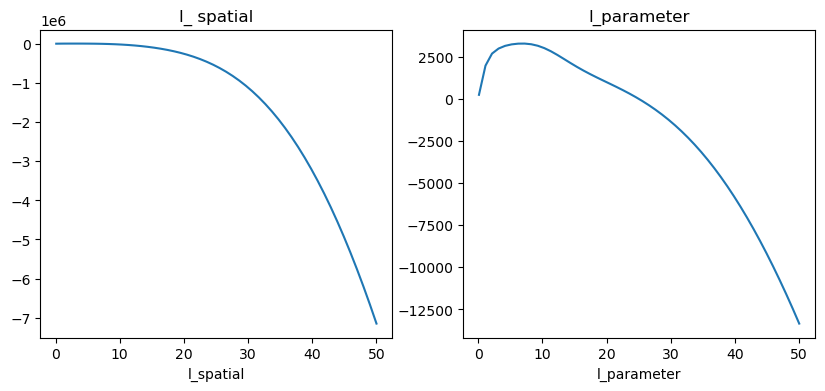

In [11]:

param = torch.linspace(0.1,50,50)
res_spa = torch.zeros_like(param)
res_para = torch.zeros_like(param)
for i,sg in enumerate(param):
    
    res_spa[i] = pigp.marginal_likelihood(torch.tensor(1), torch.tensor(sg),torch.tensor(1),torch.tensor(1))
    res_para[i] = pigp.marginal_likelihood(torch.tensor(1), torch.tensor(1),torch.tensor(1),torch.tensor(sg))

fig, axs = plt.subplots(1,2, figsize=(10, 4))

axs[0].plot(param,np.array(res_spa))
axs[0].set_title("l_ spatial")
axs[0].set_xlabel("l_spatial")

axs[1].plot(param,np.array(res_para))
axs[1].set_title("l_parameter")
axs[1].set_xlabel("l_parameter")

(-0.001, 300.0)

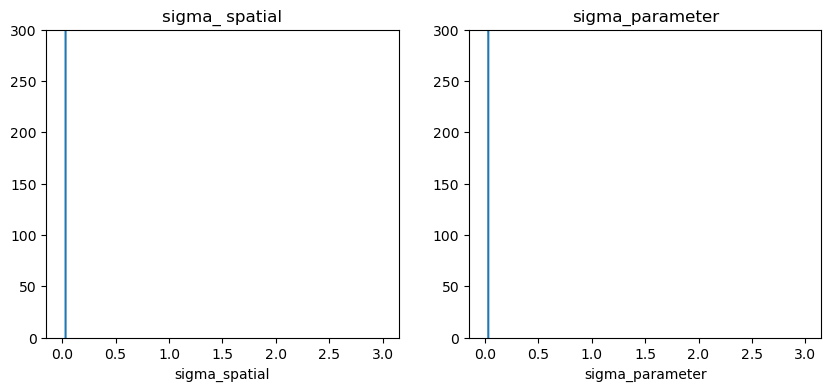

In [ ]:
param = torch.linspace(1e-3,3,100)
res_spa = torch.zeros_like(param)
res_para = torch.zeros_like(param)
for i,sg in enumerate(param):
    
    res_spa[i] = pigp.marginal_likelihood(torch.tensor(sg), torch.tensor(1),torch.tensor(1),torch.tensor(1))
    res_para[i] = pigp.marginal_likelihood(torch.tensor(1), torch.tensor(1),torch.tensor(sg),torch.tensor(1))

fig, axs = plt.subplots(1,2, figsize=(10, 4))

axs[0].plot(param,np.array(res_spa))
axs[0].set_title("sigma_ spatial")
axs[0].set_xlabel("sigma_spatial")
#axs[0].set_ylim((-1e-3,300))

axs[1].plot(param,np.array(res_para))
axs[1].set_title("sigma_parameter")
axs[1].set_xlabel("sigma_parameter")
#axs[1].set_ylim((-1e-3,300))

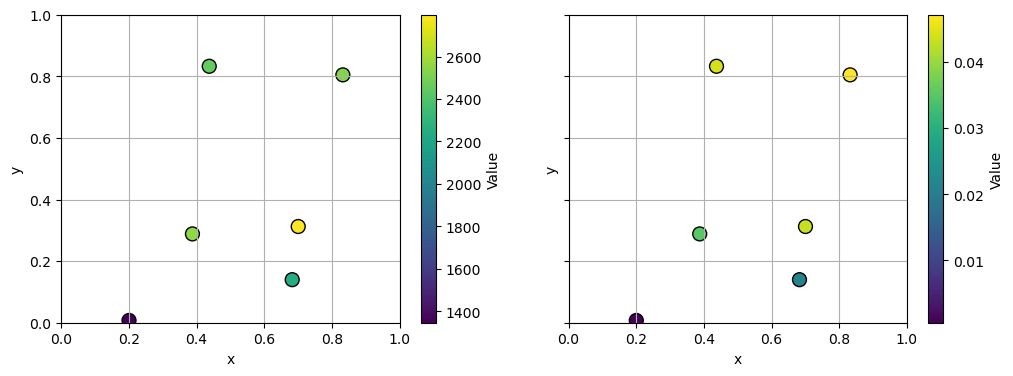

In [13]:
fig, axs = plt.subplots(1,2, figsize=(12, 4), sharey="row", sharex="col")

mean, var  = pigp.prediction(pigp.parameters_data[0,:].reshape(1,-1))

values_flat = mean.ravel()
fem_flat = training_data[0,:].ravel()

# Plot
scatter = axs[0].scatter(
    obs_points[:,0], obs_points[:,1],
    c=values_flat,
    cmap='viridis',
    s=100,
    edgecolor='black'
)

plt.colorbar(scatter, label='Value')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim(0,1)
axs[0].set_ylim(0,1)
axs[0].grid(True)

scatter = axs[1].scatter(
    obs_points[:,0], obs_points[:,1],
    c=fem_flat,
    cmap='viridis',
    s=100,
    edgecolor='black'
)

plt.colorbar(scatter, label='Value')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[1].grid(True)


[[0.1999082  0.00736227]
 [0.78692438 0.66485086]
 [0.70516538 0.78072903]
 [0.45891578 0.5687412 ]
 [0.139797   0.11453007]
 [0.66840296 0.47109621]]


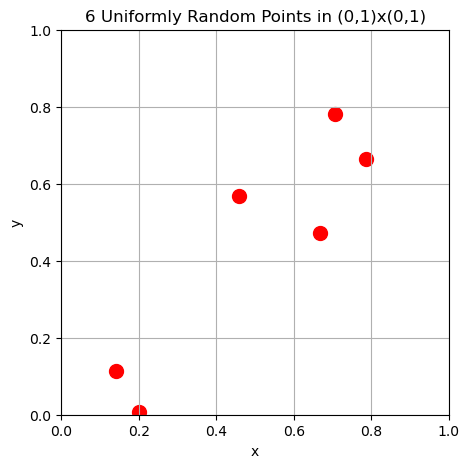

In [68]:
rng = np.random.default_rng(42)

obs, nthetas = 6, 10
nparams = 5

theta = rng.uniform(low = -1,high = 1,size=(nthetas,nparams))
fem_solver = Elliptic2D_FEM(np.zeros(nparams),ncells = 30)
points = rng.uniform(low=0.0, high=1.0, size=(obs, 2))
points_fem = np.hstack((points, np.zeros((points.shape[0], 1))))

print(points)

# Plot them
plt.figure(figsize=(5,5))
plt.scatter(points[:,0], points[:,1], color='red', s=100, marker='o')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('6 Uniformly Random Points in (0,1)x(0,1)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

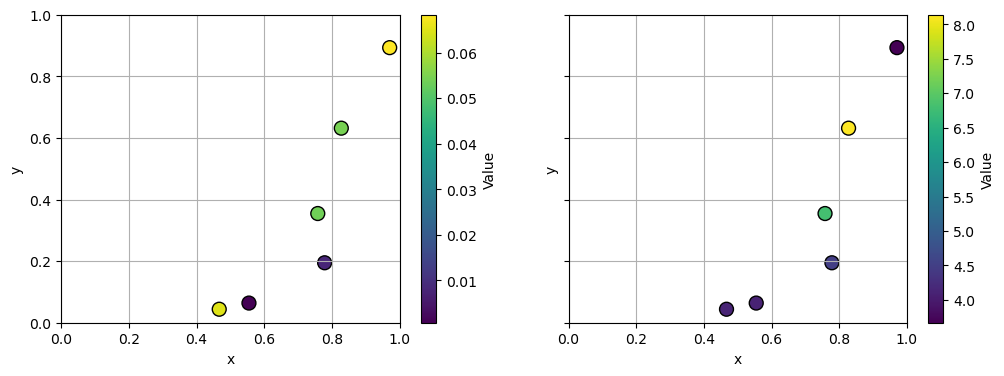

In [69]:
#rng = np.random.default_rng(0)
rng = np.random
obs, nthetas = 6, 8
nparams = 2

thetas = rng.uniform(low = -1,high = 1,size=(nthetas,nparams))

fem_solver.theta = thetas[0,:]
fem_solver.solve()
res = fem_solver.evaluate_at_points(points_fem)
mean, var  = pigp.prediction(torch.tensor(thetas[0,:]).reshape(1,-1))

fem_flat = res.ravel()
gp_flat = mean.ravel()
fig, axs = plt.subplots(1,2, figsize=(12, 4), sharey="row", sharex="col")

scatter = axs[0].scatter(
    obs_points[:,0], obs_points[:,1],
    c=fem_flat,
    cmap='viridis',
    s=100,
    edgecolor='black'
)

plt.colorbar(scatter, label='Value')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim(0,1)
axs[0].set_ylim(0,1)
axs[0].grid(True)

scatter = axs[1].scatter(
    obs_points[:,0], obs_points[:,1],
    c=gp_flat,
    cmap='viridis',
    s=100,
    edgecolor='black'
)

plt.colorbar(scatter, label='Value')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[1].grid(True)

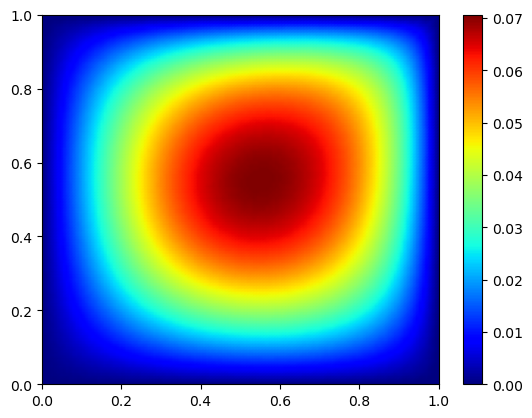

In [70]:
from scipy.interpolate import griddata, interp2d

xgrid = np.linspace(0,1,128)
X, Y = np.meshgrid(xgrid, xgrid)
points_ = np.column_stack((X.ravel(), Y.ravel(), np.zeros_like(X.ravel())))  # shape (N, 3)
u_values = fem_solver.evaluate_at_points(points_)
z_pred = griddata((X.reshape(-1), Y.reshape(-1)), u_values.flatten(),
                    (X, Y), method='cubic')

pcm =plt.pcolormesh(X, Y, z_pred, shading="gouraud", cmap = "jet")
plt.colorbar(pcm)  # Add colorbar based on the plot



In [7]:

import torch
from torch.distributions import MultivariateNormal

from Base.mcmc import MetropolisHastings,MCMCDA
from Base.lla import dgala

from elliptic2d_files.FEM2d_Solver import Elliptic2D_FEM
from elliptic2d_files.elliptic2d import Elliptic2D

import time

class EllipticMCMC(MetropolisHastings):
    def __init__(self, surrogate, observation_locations, observations_values, nparameters=2, 
                 observation_noise=0.5, nsamples=1000000, burnin=None, proposal_type="random_walk",
                 step_size=0.1,uniform_limit=1,my_reg = 1e-3, device="cpu"):
        
        super(EllipticMCMC, self).__init__(observation_locations =observation_locations, observations_values=observations_values, nparameters=nparameters, 
                 observation_noise=observation_noise, nsamples=nsamples, burnin=burnin, proposal_type=proposal_type, step_size=step_size,
                 uniform_limit=uniform_limit,my_reg=my_reg,device=device)
        
        self.surrogate = surrogate
        self.device = device

        # Dictionary to map surrogate classes to their likelihood functions
        likelihood_methods = {Elliptic2D_FEM: self.fem_log_likelihood,
                              EllipticPIGP:self.gp_log_likelihood,
                                   Elliptic2D: self.nn_log_likelihood,
                                   dgala: self.dgala_log_likelihood}

        # Precompute the likelihood function at initialization
        surrogate_type = type(surrogate)
        if surrogate_type in likelihood_methods:
            self.log_likelihood_func = likelihood_methods[surrogate_type]
        else:
            raise ValueError(f"Surrogate of type {surrogate_type.__name__} is not supported.")


    def fem_log_likelihood(self, theta ):
        """
        Evaluates the log-likelihood given a FEM.
        """
        self.surrogate.theta = theta.cpu().numpy()  # Convert to numpy for FEM solver
        self.surrogate.solve()
        surg = self.surrogate.eval_at_points(self.observation_locations.cpu().numpy()).reshape(-1, 1)
        surg = torch.tensor(surg, device=self.device)
        return -0.5 * torch.sum(((self.observations_values - surg) ** 2) / (self.observation_noise ** 2))
    
    def gp_log_likelihood(self,theta):
        """
        Evaluates the log-likelihood given a GP.
        """
        #mean_surg, var_surg = self.surrogate.prediction(jnp.array(theta.detach().numpy()).reshape(1,-1))
        #mean_surg, var_surg = self.surrogate.prediction(theta.reshape(1,-1),var=True)
        mean_surg = self.surrogate.prediction(theta.reshape(1,-1),var=False)


        #mean_surg, var_surg = torch.tensor(np.array(mean_surg)),torch.tensor(np.array(var_surg))
        dy = mean_surg.shape[0]

        diff = (self.observations_values - mean_surg.reshape(-1, 1))
        nll = -0.5 * torch.sum((diff ** 2) / (self.observation_noise ** 2))

        return nll

        # sigma = var_surg +  torch.diag(torch.ones(dy) * self.observation_noise ** 2)

        # L = torch.linalg.cholesky(sigma)
        # k_inv_g = torch.linalg.solve(sigma,diff) 

        # cte = 0.5 * (dy * torch.log(torch.tensor(2 * torch.pi)) + 2.0 * torch.sum(torch.log(torch.diag(L))))

        # # Log-likelihood
        # lg = -0.5 * torch.matmul(diff.T, k_inv_g)- cte
        # return lg.squeeze()

    def nn_log_likelihood(self, theta):
        """
        Evaluates the log-likelihood given a NN.
        """
        data = torch.cat([self.observation_locations, theta.repeat(self.observation_locations.size(0), 1)], dim=1).float()
        surg = self.surrogate.u(data.float()).detach()
        return -0.5 * torch.sum(((self.observations_values - surg) ** 2) / (self.observation_noise ** 2))

    def dgala_log_likelihood(self, theta):
        """
        Evaluates the log-likelihood given a dgala.
        """
        data = torch.cat([self.observation_locations, theta.repeat(self.observation_locations.size(0), 1)], dim=1).float()
        surg_mu, surg_sigma = self.surrogate(data)

        surg_mu = surg_mu.view(-1, 1)
        surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

        sigma = self.observation_noise ** 2 + surg_sigma
        dy = surg_mu.shape[0]

        cte = 0.5 * (dy * torch.log(torch.tensor(2 * torch.pi)) + torch.sum(torch.log(sigma)))

        return -0.5 * torch.sum(((self.observations_values - surg_mu.reshape(-1, 1)) ** 2) / sigma)- cte
    
    def log_likelihood(self, theta):
        """Directly call the precomputed likelihood function."""
        return self.log_likelihood_func(theta)


In [8]:
from elliptic2d_files.utilities import generate_noisy_obs,deepgala_data_fit

rng = np.random.default_rng(42)

noise_level = 1e-4
kl =2
obs_points, sol_test,_ = generate_noisy_obs(obs=obs,
                                            std=np.sqrt(noise_level),
                                            nparam=kl,
                                            ncells=50)
obs, nthetas = 6, 8
nparams = 2

thetas = rng.uniform(low = -1,high = 1,size=(nthetas,nparams))
fem_solver = Elliptic2D_FEM(np.zeros(nparams),ncells = 30)
points_fem = np.hstack((obs_points, np.zeros((obs_points.shape[0], 1))))

training_data = np.zeros((nthetas,obs ))
for i,tht in enumerate(thetas):
    fem_solver.theta = tht
    
    start = time.time()
    fem_solver.solve()
    end = time.time()
    print(f"Time taken: {end - start} seconds")

    training_data[i,:] = fem_solver.evaluate_at_points(points_fem).reshape(1, -1)

xf = np.array([
    [0.2, 0.2],
    [0.8, 0.2],
    [0.2, 0.8],
    [0.8, 0.8],
    [0.5, 0.5],
    [0.2, 0.5],
    [0.5, 0.2],
    [0.8, 0.5],
    [0.5, 0.8],
    [0.35, 0.35]
])

yf = 4 * xf[:, 0] * xf[:, 1]

grid = torch.linspace(0.1, 0.9, 5)

# Bottom edge: y=0
bottom = torch.stack([grid, torch.full_like(grid, 0)], dim=1)

# Top edge: y=1
top = torch.stack([grid, torch.full_like(grid, 1)], dim=1)

# Left edge: x=0
left = torch.stack([torch.full_like(grid, 0), grid], dim=1)

# Right edge: x=1
right = torch.stack([torch.full_like(grid, 1), grid], dim=1)

# Concatenate all boundary points
boundary_points = torch.cat([bottom, top, left, right], dim=0)

y_bc = torch.zeros((boundary_points.shape[0],1))

data_training = {"parameters_data": torch.tensor(thetas),
                 "solutions_data": torch.tensor(training_data),
                 "x_solutions_data":obs_points,
                 "x_bc": boundary_points,
                 "y_bc": y_bc,
                 "source_func_x": xf,
                 "source_func_f_x":yf.reshape(-1,1)
                   }
print(obs_points)

pigp = EllipticPIGP(data_training=data_training, sigma_l_spatial=(1,10))

pigp.train_gp()
#a = pigp.kernel_ff(pigp.parameters_data[1],pigp.parameters_data[1])
#ddk_dxidxj,ddk_dyidyj,dddk_dxiddxj,dddk_dyiddyj,dddk_ddxidxj,dddk_ddyidyj,ddddk_dx,ddddk_dy = pigp.kernel_partials(pigp.source_func_x,pigp.source_func_x)
#res
pigp.optimize_mll()

Time taken: 0.016914844512939453 seconds
Time taken: 0.016617774963378906 seconds
Time taken: 0.016680002212524414 seconds
Time taken: 0.017592906951904297 seconds
Time taken: 0.01515507698059082 seconds
Time taken: 0.014829158782958984 seconds
Time taken: 0.014589071273803711 seconds
Time taken: 0.014672517776489258 seconds
[[0.77395605 0.43887844]
 [0.85859792 0.69736803]
 [0.09417735 0.97562235]
 [0.7611397  0.78606431]
 [0.12811363 0.45038594]
 [0.37079802 0.92676499]]
Optimized parameters:
(sigma_spatial,l_spatial) = (0.1723363163776926,0.3116882672025948)
(sigma_parameter,l_parameter) = (0.17233631671945615,4.963684647722933)


In [9]:
from elliptic2d_files.utilities import generate_noisy_obs,deepgala_data_fit

noise_level = 1e-4
kl =2
obs_points, sol_test,_ = generate_noisy_obs(obs=obs,
                                            std=np.sqrt(noise_level),
                                            nparam=kl,
                                            ncells=50)
obs_points

array([[0.77395605, 0.43887844],
       [0.85859792, 0.69736803],
       [0.09417735, 0.97562235],
       [0.7611397 , 0.78606431],
       [0.12811363, 0.45038594],
       [0.37079802, 0.92676499]])

In [10]:
elliptic_mcmcda = EllipticMCMC(
        surrogate=pigp,
        observation_locations=obs_points,
        observations_values=sol_test,
        observation_noise=np.sqrt(noise_level),
        nparameters=kl,
        nsamples=1_500_000,
        proposal_type="pCN",
        step_size=0.01,
        uniform_limit = 1,
    )

In [11]:
gp_samples = elliptic_mcmcda.run_chain()


Running MCMC:   0%|          | 0/1650000 [00:00<?, ?step/s]

Running MCMC: 100%|██████████| 1650000/1650000 [03:40<00:00, 7498.16step/s, acceptance_rate=0.2436, proposal_variance=0.8868]


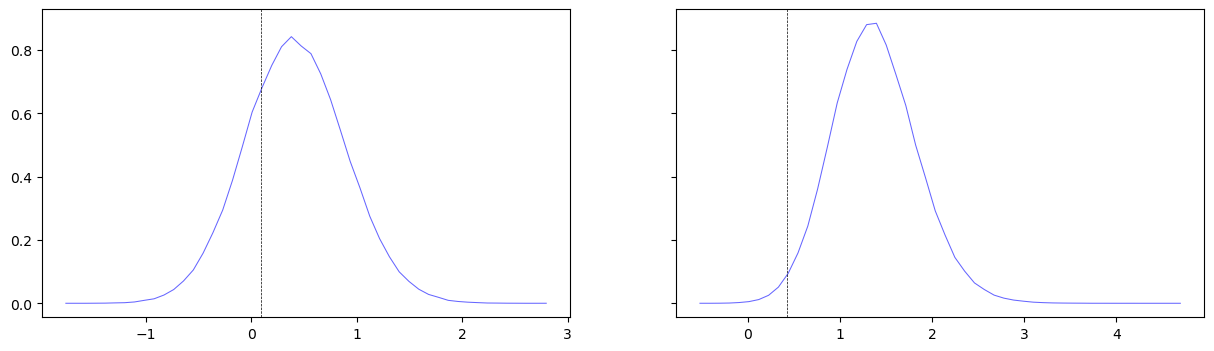

In [12]:
from Base.utilities import histogram_,stat_ar
bins = 50
theta_th =  np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
#sample= np.load(f'./results/PIGP2D_mean_spatial6_nsol10_kl2_var0.0001.npy')
sample = gp_samples[0]
param_dim = sample.shape[-1]

fig, axs = plt.subplots(1,param_dim, figsize=(15, 4), sharey="row", sharex="col")

for i in range(param_dim):
    bin_centers, counts = histogram_(sample[:, i],bins=bins)
    axs[i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75, label = r"$\pi_{\text{mean}}$",color = "blue")
    axs[i].axvline(x=theta_th[i], color='black', linestyle="--", linewidth=0.5)

#axs[0].set_xlim((-0.3,0.6)),axs[1].set_xlim((0.25,0.5))
